In [1]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import math
import random


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

from keras.models import Sequential
from keras.layers import Dense, LSTM, RNN, GRU, Dropout, Activation
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import SimpleRNN, Embedding
from tensorflow.keras.preprocessing import sequence

from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import skew, kurtosis

### Read data ###

In [2]:
df = pd.read_csv('./Bitcoin Historical Data.csv')

In [3]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,06/01/2024,"67,760.8","67,533.9","67,861.0","67,449.6",19.01K,0.34%
1,05/31/2024,"67,530.1","68,352.3","69,018.2","66,676.8",61.51K,-1.21%
2,05/30/2024,"68,354.7","67,631.3","69,504.7","67,138.4",66.84K,1.06%
3,05/29/2024,"67,635.8","68,366.2","68,897.6","67,143.2",52.13K,-1.07%
4,05/28/2024,"68,366.0","69,428.3","69,560.7","67,299.9",71.39K,-1.53%


In [4]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1920 non-null   object
 1   Price     1920 non-null   object
 2   Open      1920 non-null   object
 3   High      1920 non-null   object
 4   Low       1920 non-null   object
 5   Vol.      1920 non-null   object
 6   Change %  1920 non-null   object
dtypes: object(7)
memory usage: 105.1+ KB


In [5]:
def convert_to_number(price_str):
    price_str = price_str.replace(",", "")  # Remove any commas
    if 'K' in price_str:
        return float(price_str.replace('K', '')) * 1000
    elif 'M' in price_str:
        return float(price_str.replace('M', '')) * 1000000
    elif 'B' in price_str:
        return float(price_str.replace('B', '')) * 1000000000
    elif '%' in price_str:
        return float(price_str.replace('%', '')) / 100
    else:
        return float(price_str)

In [6]:
df['Date']  = pd.to_datetime(df['Date'])
df.reset_index(drop=True)
df.set_index('Date', inplace=True)
df['Vol.']   = df['Vol.'].apply(convert_to_number)
df.rename(columns={'Vol.': 'Vol'}, inplace=True)
df['Change %'] = df['Change %'].apply(convert_to_number)
df.rename(columns={'Change %': 'Change'}, inplace=True)
df['Price'] = df['Price'].apply(convert_to_number)
df['Open']  = df['Open'].apply(convert_to_number)
df['High']  = df['High'].apply(convert_to_number)
df['Low']   = df['Low'].apply(convert_to_number)

In [7]:
df.sort_index(ascending=True, inplace=True)

In [8]:
df.head()

,Price,Open,High,Low,Vol,Change
Date,,,,,,
2019-03-01,3821.9,3816.7,3855.8,3816.4,1740000.0,0.0014
2019-03-02,3823.1,3821.9,3843.2,3783.6,1610000.0,0.0003
2019-03-03,3809.5,3823.2,3836.6,3789.7,1510000.0,-0.0036
2019-03-04,3715.9,3809.7,3828.4,3681.8,2850000.0,-0.0245
2019-03-05,3857.2,3715.9,3873.2,3705.7,3820000.0,0.0380


### Descriptive statistc ###

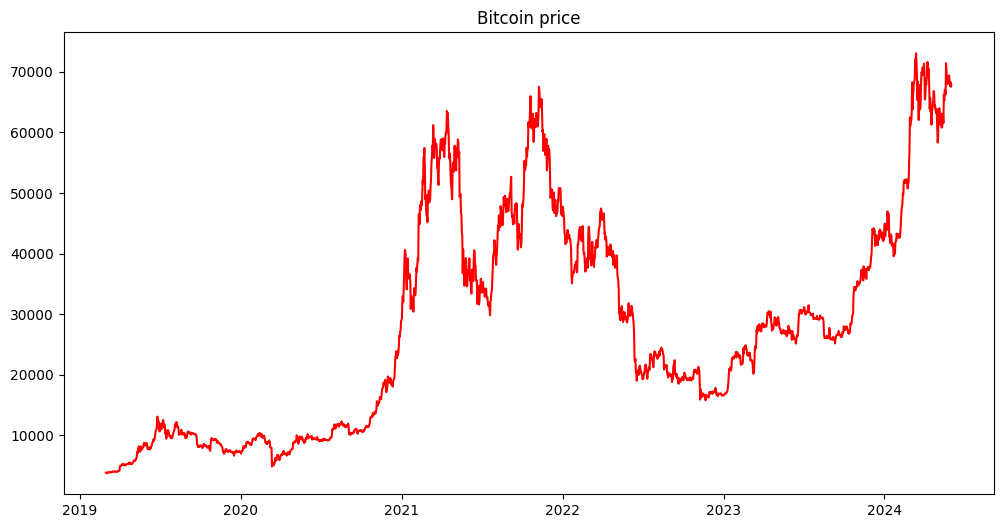

In [11]:
plt.figure(figsize=(12,6))
plt.plot(df["Price"], color='red')
plt.title('Bitcoin price')
plt.show()

<Axes: >

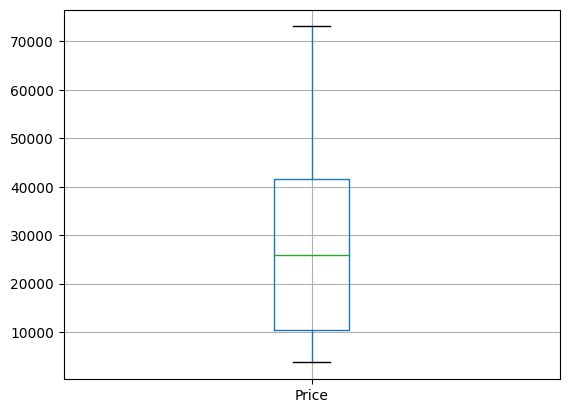

In [118]:
df.boxplot(column=['Price'])

In [119]:
column='Price'
summary = {
    'mean': df[column].mean(),
    'mode': df[column].mode()[0], 
    'std': df[column].std(),
    'var': df[column].var(),
    'kurtosis': kurtosis(df[column]),
    'skewness': skew(df[column]),
    'range': df[column].max() - df[column].min(),
    'min': df[column].min(),
    'max': df[column].max(),
    'sum': df[column].sum(),
    'count': df[column].count(),
    'median': df[column].median()
}

print(f"Summary statistics for column {column}:")
for stat, value in summary.items():
    print(f"{stat}: {value}")


Summary statistics for column Price:
mean: 27920.39703125
mode: 7196.4
std: 17920.190889380498
var: 321133241.51183575
kurtosis: -0.6942125412759332
skewness: 0.5754163357302351
range: 69350.40000000001
min: 3715.9
max: 73066.3
sum: 53607162.3
count: 1920
median: 25933.35


In [120]:
df['Price'].describe()

count     1920.000000
mean     27920.397031
std      17920.190889
min       3715.900000
25%      10435.625000
50%      25933.350000
75%      41491.000000
max      73066.300000
Name: Price, dtype: float64

### Preprocess data ###

In [121]:

df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day

In [122]:
df.head()

,Price,Open,High,Low,Vol,Change,Year,Month,Day
Date,,,,,,,,,
2019-03-01,3821.9,3816.7,3855.8,3816.4,1740000.0,0.0014,2019,3,1
2019-03-02,3823.1,3821.9,3843.2,3783.6,1610000.0,0.0003,2019,3,2
2019-03-03,3809.5,3823.2,3836.6,3789.7,1510000.0,-0.0036,2019,3,3
2019-03-04,3715.9,3809.7,3828.4,3681.8,2850000.0,-0.0245,2019,3,4
2019-03-05,3857.2,3715.9,3873.2,3705.7,3820000.0,0.0380,2019,3,5


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1920 entries, 2019-03-01 to 2024-06-01
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   1920 non-null   float64
 1   Open    1920 non-null   float64
 2   High    1920 non-null   float64
 3   Low     1920 non-null   float64
 4   Vol     1920 non-null   float64
 5   Change  1920 non-null   float64
 6   Year    1920 non-null   int64  
 7   Month   1920 non-null   int64  
 8   Day     1920 non-null   int64  
dtypes: float64(6), int64(3)
memory usage: 150.0 KB


In [124]:
df.shape

(1920, 9)

### Parameter

In [125]:
window_size = 10
feature_dim = 5

train_size = 0.6
val_size = 0.1
test_size=0.3

# model params
lstm_neurons = 20
rnn_neurons = 20
epochs = 100
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

### Split data

In [126]:
train_index = int(len(df)*train_size)
test_index = train_index + int(len(df)*test_size)

print('train index: ',train_index)
print('test index: ',test_index)

train index:  1152
test index:  1728


In [128]:
df_30 = df.iloc[(random.randint(0, len(df) - 100)):(random.randint(0, len(df) - 100)+30)]
len(df_30)
# date_range_30 = pd.date_range(start='2024-06-02', end='2024-07-02', periods=30)
# df_30.index = date_range_30.date


815

In [129]:
df_train = df.iloc[:train_index]
df_test  = df[train_index:test_index]
df_val   = df[test_index:]

index_30 = random.randint(0, len(df) - 100)
index_60 =random.randint(0, len(df) - 100)
index_90 =random.randint(0, len(df) - 100)

df_30 = df.iloc[index_30: index_30+30]
df_60 = df.iloc[index_60: index_60+60]
df_90 = df.iloc[index_90: index_90+90]

date_range_30 = pd.date_range(start='2024-06-02', end='2024-07-02', periods=30)
date_range_60 = pd.date_range(start='2024-06-02', end='2024-08-01', periods=60)
date_range_90 = pd.date_range(start='2024-02-06', end='2024-08-31', periods=90)

df_30.index = date_range_30.date
df_60.index = date_range_60.date
df_90.index = date_range_90.date

print('df_train.shape: ',df_train.shape)
print('df_test.shape: ',df_test.shape)
print('df_val.shape: ',df_val.shape)
print('df_30.shape: ',df_30.shape)
print('df_60.shape: ',df_60.shape)
print('df_90.shape: ',df_90.shape)


df_train.shape:  (1152, 9)
df_test.shape:  (576, 9)
df_val.shape:  (192, 9)
df_30.shape:  (30, 9)
df_60.shape:  (60, 9)
df_90.shape:  (90, 9)


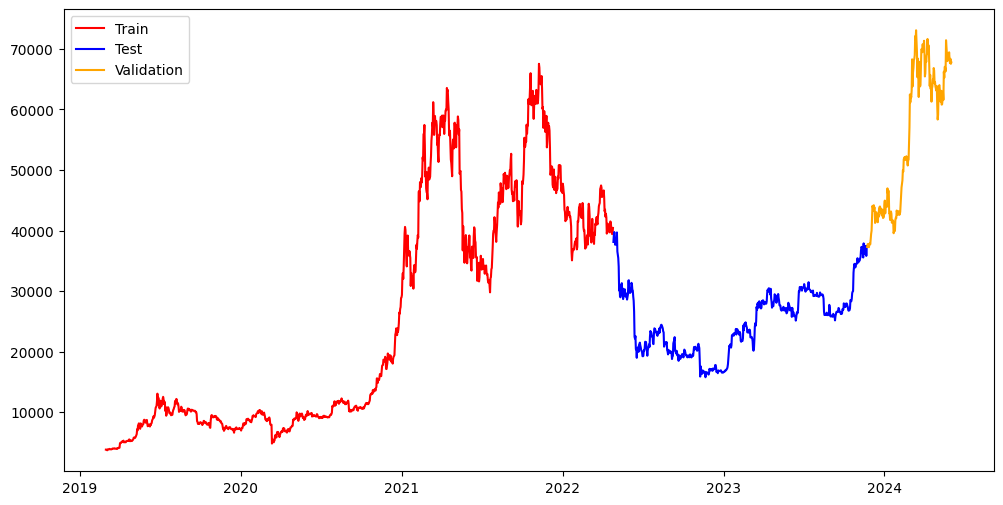

In [130]:
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(df_train).index.to_list(), pd.DataFrame(df_train['Price']), color='red', label='Train')
plt.plot(pd.DataFrame(df_test).index.to_list(),pd.DataFrame(df_test['Price']),color='blue' ,label ='Test')
plt.plot(pd.DataFrame(df_val).index.to_list(),pd.DataFrame(df_val['Price']),color ='orange', label ='Validation')
plt.legend()
plt.show()

In [131]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_train_scaled = scaler.fit_transform(df_train)
df_test_scaled = scaler.transform(df_test)
df_val_scaled = scaler.transform(df_val)
df_30_scaled = scaler.transform(df_30)
df_60_scaled = scaler.transform(df_60)
df_90_scaled = scaler.transform(df_90)


df_train_scaled = pd.DataFrame(df_train_scaled, index=df_train.index, columns=df_train.columns)
df_test_scaled = pd.DataFrame(df_test_scaled, index=df_test.index, columns=df_test.columns)
df_val_scaled = pd.DataFrame(df_val_scaled,index =df_val.index,columns=df_val.columns)
df_30_scaled = pd.DataFrame(df_30_scaled,index =df_30.index,columns=df_30.columns)
df_60_scaled = pd.DataFrame(df_60_scaled,index =df_60.index,columns=df_60.columns)
df_90_scaled = pd.DataFrame(df_90_scaled,index =df_90.index,columns=df_90.columns)

In [132]:
X_train_scale = df_train_scaled.drop(columns=['Price'])
y_train_scale = df_train_scaled['Price']

X_test_scale  = df_test_scaled.drop(columns=['Price'])
y_test_scale  = df_test_scaled['Price']

X_val_scale = df_val_scaled.drop(columns=['Price'])
y_val_scale = df_val_scaled['Price']

X_30_scale = df_30_scaled.drop(columns=['Price'])
y_30_scale = df_30_scaled['Price']

X_60_scale = df_60_scaled.drop(columns=['Price'])
y_60_scale = df_60_scaled['Price']

X_90_scale = df_90_scaled.drop(columns=['Price'])
y_90_scale = df_90_scaled['Price']

In [133]:
print('X_train_scale shape: ',X_train_scale.shape)
print('y_train_scale shape: ',y_train_scale.shape)
print('\nX_test_scale shape: ',X_test_scale.shape)
print('y_test_scale shape: ',y_test_scale.shape)
print('\nX_val_scale shape: ',X_val_scale.shape)
print('y_val_scale shape: ',y_val_scale.shape)

X_train_scale shape:  (1152, 8)
y_train_scale shape:  (1152,)

X_test_scale shape:  (576, 8)
y_test_scale shape:  (576,)

X_val_scale shape:  (192, 8)
y_val_scale shape:  (192,)


### Linear Regression ###

In [134]:
X_train_lr = X_train_scale
y_train_lr = y_train_scale

X_test_lr  = X_test_scale
y_test_lr = y_test_scale

X_val_lr = X_val_scale
y_val_lr = y_val_scale

X_30_lr = X_30_scale
X_60_lr = X_60_scale
X_90_lr = X_90_scale

In [135]:
model_LR = LinearRegression()
model_LR.fit(X_train_scale, y_train_scale)

LinearRegression()

In [136]:
pred_test_LR = model_LR.predict(X_test_scale)
pred_val_LR = model_LR.predict(X_val_lr)
pred_30_LR = model_LR.predict(X_30_lr)
pred_60_LR = model_LR.predict(X_60_lr)
pred_90_LR = model_LR.predict(X_90_lr)

In [137]:
mape = mean_absolute_percentage_error(y_test_scale, pred_test_LR)
mae = mean_absolute_error(y_test_scale,pred_test_LR)
mse = mean_squared_error(y_test_scale, pred_test_LR)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

Mean Absolute Percentage Error: 0.006426640494891326
Mean Absolute Error: 0.0020963641160616628
Root Mean Squared Error: 0.0032456641110464794


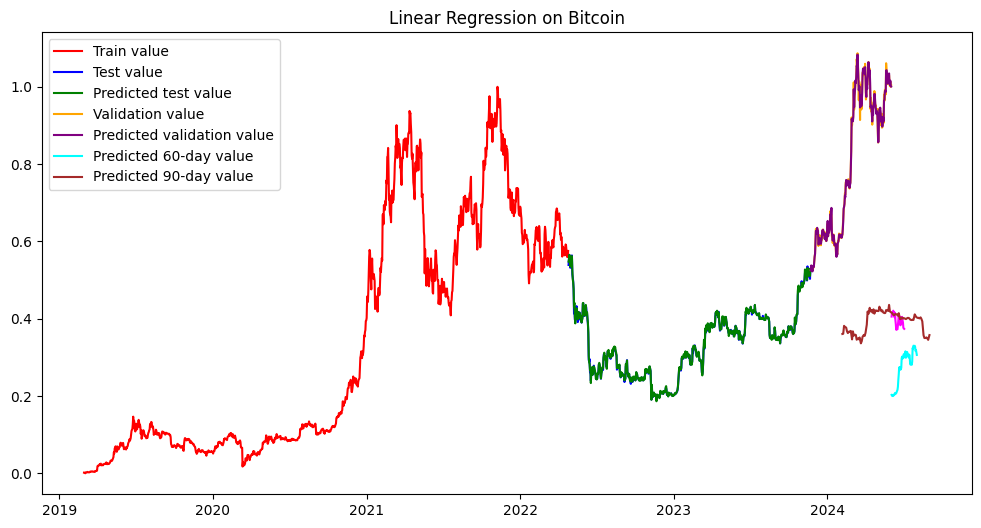

In [228]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train_scale).index.to_list(),pd.DataFrame(y_train_lr),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(y_test_lr), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(pred_test_LR.reshape(-1)), color='green', label='Predicted test value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(y_val_lr),color='orange', label='Validation value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(pred_val_LR.reshape(-1)),color='purple', label='Predicted validation value')
plt.plot(pd.DataFrame(y_30_scale).index.to_list(),pd.DataFrame(pred_30_LR.reshape(-1)),color='magenta')
plt.plot(pd.DataFrame(y_60_scale).index.to_list(), pd.DataFrame(pred_60_LR.reshape(-1)), color='cyan', label='Predicted 60-day value')
plt.plot(pd.DataFrame(y_90_scale).index.to_list(), pd.DataFrame(pred_90_LR.reshape(-1)), color='brown', label='Predicted 90-day value')
plt.title("Linear Regression on Bitcoin")
plt.legend()
plt.show()

In [139]:
model_filename = "model_LR.joblib"
joblib.dump(model_LR, model_filename)

['model_LR.joblib']

### GRU ###

In [140]:
X_train_GRU = X_train_scale.values.reshape((X_train_scale.shape[0], 1, X_train_scale.shape[1]))
y_test_GRU = y_test_scale.values

X_test_GRU = X_test_scale.values.reshape((X_test_scale.shape[0], 1, X_test_scale.shape[1]))
y_train_GRU = y_train_scale.values

X_val_GRU = X_val_scale.values.reshape((X_val_scale.shape[0], 1, X_val_scale.shape[1]))
y_val_GRU = y_val_scale

X_30_GRU = X_30_scale.values.reshape((X_30_scale.shape[0], 1, X_30_scale.shape[1]))
X_60_GRU = X_60_scale.values.reshape((X_60_scale.shape[0], 1, X_60_scale.shape[1]))
X_90_GRU = X_90_scale.values.reshape((X_90_scale.shape[0], 1, X_90_scale.shape[1]))

In [141]:
def build_GRU_model(input_shape, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):                     
    model = Sequential()

    model.add(GRU(neurons,  input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [142]:
model_GRU = build_GRU_model(
    (X_train_GRU.shape[1], X_train_GRU.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

In [143]:
history = model_GRU.fit(
    X_train_GRU, y_train_GRU, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)

In [144]:
model_GRU.save('model_GRU.h5')

In [145]:
pred_test_GRU = model_GRU.predict(X_test_GRU)
pred_val_GRU = model_GRU.predict(X_val_GRU)
pred_30_GRU = model_GRU.predict(X_30_GRU)
pred_60_GRU = model_GRU.predict(X_60_GRU)
pred_90_GRU = model_GRU.predict(X_90_GRU)

3/3 [==============================] - 0s 2ms/step


In [146]:
mape = mean_absolute_percentage_error(y_test_GRU, pred_test_GRU)
mae = mean_absolute_error(y_test_GRU,pred_test_GRU)
mse = mean_squared_error(y_test_GRU, pred_test_GRU)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

Mean Absolute Percentage Error: 0.050962789665886285
Mean Absolute Error: 0.01693270932331279
Root Mean Squared Error: 0.017822781739435776


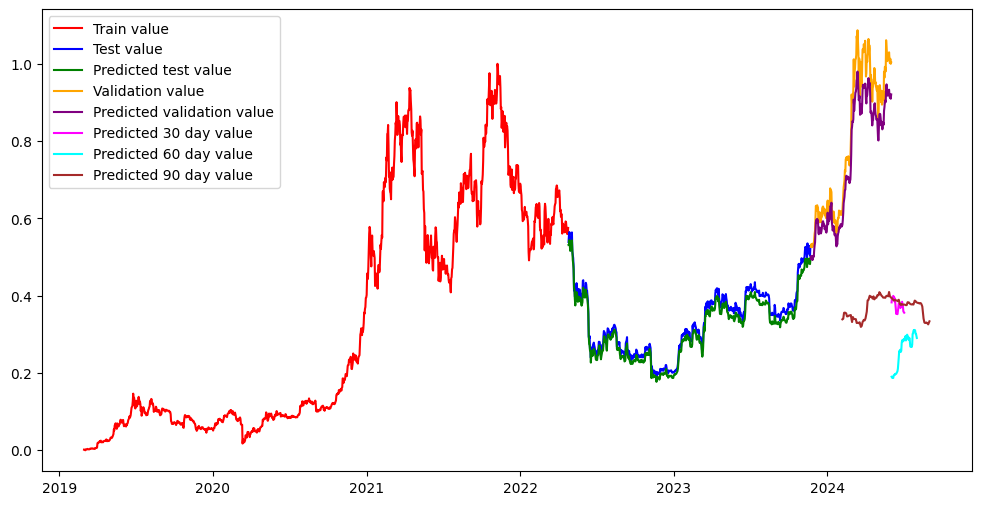

In [147]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train_scale).index.to_list(),pd.DataFrame(y_train_GRU),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(y_test_GRU), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(pred_test_GRU.reshape(-1)), color='green', label='Predicted test value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(y_val_GRU),color='orange', label='Validation value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(pred_val_GRU.reshape(-1)),color='purple', label='Predicted validation value')
plt.plot(pd.DataFrame(y_30_scale).index.to_list(), pd.DataFrame(pred_30_GRU.reshape(-1)), color='magenta', label='Predicted 30 day value')
plt.plot(pd.DataFrame(y_60_scale).index.to_list(), pd.DataFrame(pred_60_GRU.reshape(-1)), color='cyan', label='Predicted 60 day value')
plt.plot(pd.DataFrame(y_90_scale).index.to_list(), pd.DataFrame(pred_90_GRU.reshape(-1)), color='brown', label='Predicted 90 day value')
plt.title("GRU on Bitcoin")
plt.legend()
plt.show()

### RNN ###

In [148]:
X_train_RNN = X_train_scale.values.reshape((X_train_scale.shape[0], 1, X_train_scale.shape[1]))
y_test_RNN = y_test_scale.values

X_test_RNN = X_test_scale.values.reshape((X_test_scale.shape[0], 1, X_test_scale.shape[1]))
y_train_RNN = y_train_scale.values

X_val_RNN = X_val_scale.values.reshape((X_val_scale.shape[0], 1, X_val_scale.shape[1]))
y_val_RNN = y_val_scale

X_30_RNN = X_30_scale.values.reshape((X_30_scale.shape[0], 1, X_30_scale.shape[1]))
X_60_RNN = X_60_scale.values.reshape((X_60_scale.shape[0], 1, X_60_scale.shape[1]))
X_90_RNN = X_90_scale.values.reshape((X_90_scale.shape[0], 1, X_90_scale.shape[1]))

In [149]:
def build_RNN_model(input_shape, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'): 
    model = Sequential()
    model.add(SimpleRNN(50, activation='relu', input_shape=input_shape))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(optimizer='adam', loss='mse')

    model.compile(loss =loss, optimizer=optimizer)
    return model

In [150]:
model_RNN = build_RNN_model((X_train_RNN.shape[1],X_train_RNN.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

In [151]:
history = model_RNN.fit(
    X_train_RNN, y_train_RNN, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)

In [152]:
model_RNN.save('model_RNN.h5')

In [153]:
pred_test_RNN = model_RNN.predict(X_test_RNN)
pred_val_RNN = model_RNN.predict(X_val_RNN)
pred_30_RNN = model_RNN.predict(X_30_RNN)
pred_60_RNN = model_RNN.predict(X_60_RNN)
pred_90_RNN = model_RNN.predict(X_90_RNN)

3/3 [==============================] - 0s 4ms/step


In [154]:
mape = mean_absolute_percentage_error(y_test_RNN, pred_test_RNN)
mae = mean_absolute_error(y_test_RNN,pred_test_RNN)
mse = mean_squared_error(y_test_RNN, pred_test_RNN)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

Mean Absolute Percentage Error: 0.040907153355477115
Mean Absolute Error: 0.012412649709912422
Root Mean Squared Error: 0.013663400275757041


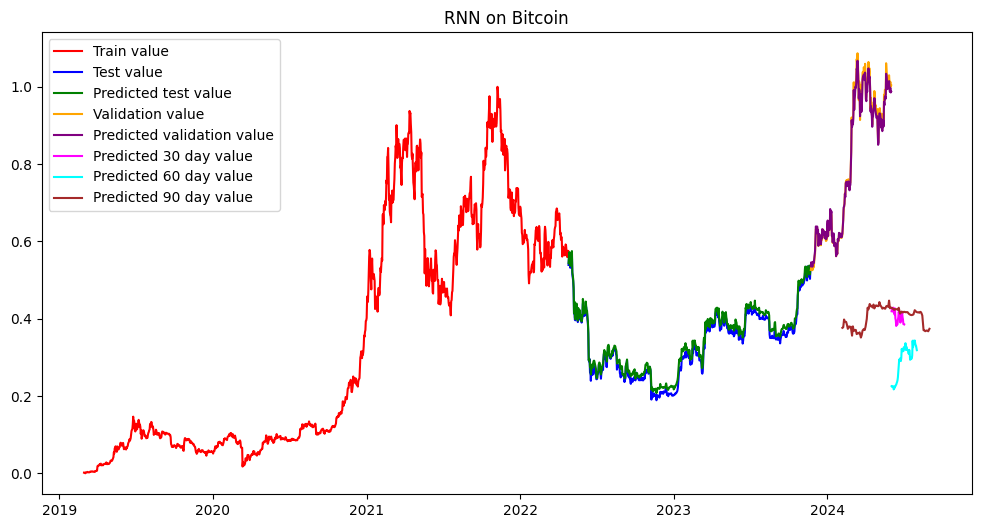

In [229]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train_scale).index.to_list(),pd.DataFrame(y_train_RNN),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(y_test_RNN), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(pred_test_RNN.reshape(-1)), color='green', label='Predicted test value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(y_val_RNN),color='orange', label='Validation value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(pred_val_RNN.reshape(-1)),color='purple', label='Predicted validation value')
plt.plot(pd.DataFrame(y_30_scale).index.to_list(), pd.DataFrame(pred_30_RNN.reshape(-1)), color='magenta', label='Predicted 30 day value')
plt.plot(pd.DataFrame(y_60_scale).index.to_list(), pd.DataFrame(pred_60_RNN.reshape(-1)), color='cyan', label='Predicted 60 day value')
plt.plot(pd.DataFrame(y_90_scale).index.to_list(), pd.DataFrame(pred_90_RNN.reshape(-1)), color='brown', label='Predicted 90 day value')
plt.title("RNN on Bitcoin")
plt.legend()
plt.show()

### LSTM ###

In [156]:
X_train_LSTM = X_train_scale.values.reshape((X_train_scale.shape[0], 1, X_train_scale.shape[1]))
y_test_LSTM  = y_test_scale.values

X_test_LSTM  = X_test_scale.values.reshape((X_test_scale.shape[0], 1, X_test_scale.shape[1]))
y_train_LSTM  = y_train_scale.values

X_val_LSTM = X_val_scale.values.reshape((X_val_scale.shape[0], 1, X_val_scale.shape[1]))
y_val_LSTM = y_val_scale

X_30_LSTM = X_30_scale.values.reshape((X_30_scale.shape[0], 1, X_30_scale.shape[1]))
X_60_LSTM = X_60_scale.values.reshape((X_60_scale.shape[0], 1, X_60_scale.shape[1]))
X_90_LSTM = X_90_scale.values.reshape((X_90_scale.shape[0], 1, X_90_scale.shape[1]))

In [157]:
def build_lstm_model(input_shape, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [158]:
model_LSTM = build_lstm_model(
    (X_train_LSTM.shape[1],X_train_LSTM.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

In [159]:
history = model_LSTM.fit(
    X_train_LSTM, y_train_LSTM, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)

In [160]:
model_LSTM.save('model_LSTM.h5')

In [161]:
pred_test_LSTM = model_LSTM.predict(X_test_LSTM)
pred_val_LSTM = model_LSTM.predict(X_val_LSTM)
pred_30_LSTM = model_LSTM.predict(X_30_RNN)
pred_60_LSTM = model_LSTM.predict(X_60_RNN)
pred_90_LSTM = model_LSTM.predict(X_90_RNN)

3/3 [==============================] - 0s 5ms/step


In [162]:
mape = mean_absolute_percentage_error(y_test_LSTM, pred_test_LSTM)
mae = mean_absolute_error(y_test_LSTM,pred_test_LSTM)
mse = mean_squared_error(y_test_LSTM, pred_test_LSTM)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

Mean Absolute Percentage Error: 0.04241502451076751
Mean Absolute Error: 0.014967643746622347
Root Mean Squared Error: 0.016668654860024144


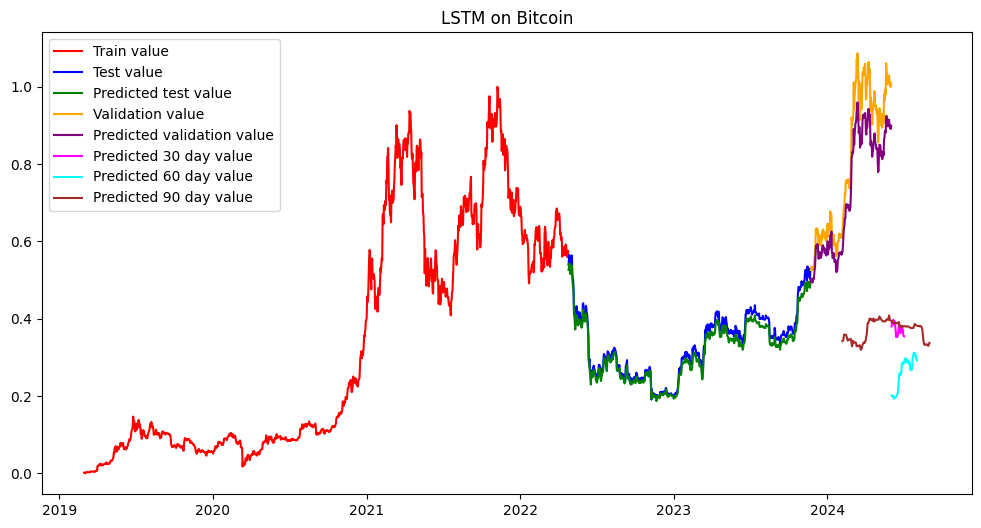

In [230]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train_scale).index.to_list(),pd.DataFrame(y_train_LSTM),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(y_test_LSTM), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(pred_test_LSTM.reshape(-1)), color='green', label='Predicted test value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(y_val_LSTM),color='orange', label='Validation value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(pred_val_LSTM.reshape(-1)),color='purple', label='Predicted validation value')
plt.plot(pd.DataFrame(y_30_scale).index.to_list(), pd.DataFrame(pred_30_LSTM.reshape(-1)), color='magenta', label='Predicted 30 day value')
plt.plot(pd.DataFrame(y_60_scale).index.to_list(), pd.DataFrame(pred_60_LSTM.reshape(-1)), color='cyan', label='Predicted 60 day value')
plt.plot(pd.DataFrame(y_90_scale).index.to_list(), pd.DataFrame(pred_90_LSTM.reshape(-1)), color='brown', label='Predicted 90 day value')
plt.title("LSTM on Bitcoin")
plt.legend()
plt.show()

### AUTOFORMER ###

### SARIMAX ###

### STACKING MODELS ###

In [190]:
X_train_SM = X_train_scale.values.reshape((X_train_scale.shape[0], 1, X_train_scale.shape[1]))
y_train_SM  = y_train_scale.values

X_test_SM  = X_test_scale.values.reshape((X_test_scale.shape[0], 1, X_test_scale.shape[1]))
y_test_SM  = y_test_scale.values

X_val_SM = X_val_scale.values.reshape((X_val_scale.shape[0], 1, X_val_scale.shape[1]))
y_val_SM = y_val_scale

X_30_SM = X_30_scale.values.reshape((X_30_scale.shape[0], 1, X_30_scale.shape[1]))
X_60_SM = X_60_scale.values.reshape((X_60_scale.shape[0], 1, X_60_scale.shape[1]))
X_90_SM = X_90_scale.values.reshape((X_90_scale.shape[0], 1, X_90_scale.shape[1]))


In [191]:
print('X_train_SM shape: ',X_train_SM.shape)
print('y_train_SM shape: ',y_train_SM.shape)
print('X_test_SM shape: ',X_test_SM.shape)
print('y_test_SM shape: ',y_test_SM.shape)

X_train_SM shape:  (1152, 1, 8)
y_train_SM shape:  (1152,)
X_test_SM shape:  (576, 1, 8)
y_test_SM shape:  (576,)


In [192]:
kf = KFold(n_splits=4,shuffle=False)

#### Base model ####

In [193]:
base_model_GRU = build_GRU_model(
    (X_train_SM.shape[1],X_train_SM.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

In [194]:
base_model_LSTM = build_lstm_model(
    (X_train_SM.shape[1],X_train_SM.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

##### First base model (GRU) #####

In [195]:
X_train_GRU_stacking = pd.DataFrame()
y_30_GRU_stacking = {}
y_60_GRU_stacking = {}
y_90_GRU_stacking = {}
y_val_GRU_stacking = {}
y_train_GRU_stacking = pd.DataFrame()
y_test_SM_GRU={}
i=0
for train_index, test_index in kf.split(X_train_SM):
    X_train_fold, X_test_fold = X_train_SM[train_index], X_train_SM[test_index]
    y_train_fold, y_test_fold = y_train_SM[train_index], y_train_SM[test_index]
    base_model_GRU.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=1)
    y_test_fold_predict = base_model_GRU.predict(X_test_fold)
    y_test_SM_GRU[f'y_test_SM_GRU_{i}'] = base_model_GRU.predict(X_test_SM)
    y_30_GRU_stacking[f'y_30_GRU_stacking_{i}'] = base_model_GRU.predict(X_30_SM)
    y_60_GRU_stacking[f'y_60_GRU_stacking_{i}'] = base_model_GRU.predict(X_60_SM)
    y_90_GRU_stacking[f'y_90_GRU_stacking_{i}'] = base_model_GRU.predict(X_90_SM)
    y_val_GRU_stacking[f'y_val_GRU_stacking_{i}'] = base_model_GRU.predict(X_val_SM)
    i+=1
    y_pred_fold_df = pd.DataFrame(y_test_fold_predict, columns=['Prediction'])
    y_test_fold_df = pd.DataFrame(y_test_fold, columns=['Prediction'])
    X_train_GRU_stacking = pd.concat([X_train_GRU_stacking, y_pred_fold_df], axis=0, ignore_index=True)
    y_train_GRU_stacking = pd.concat([y_train_GRU_stacking,y_test_fold_df], axis=0, ignore_index=True)
    

Epoch 1/10
27/27 [==============================] - 2s 3ms/step - loss: 0.2991
Epoch 2/10
27/27 [==============================] - 0s 3ms/step - loss: 0.1859
Epoch 3/10
27/27 [==============================] - 0s 3ms/step - loss: 0.1284
Epoch 4/10
27/27 [==============================] - 0s 2ms/step - loss: 0.0967
Epoch 5/10
27/27 [==============================] - 0s 2ms/step - loss: 0.0814
Epoch 6/10
27/27 [==============================] - 0s 2ms/step - loss: 0.0703
Epoch 7/10
27/27 [==============================] - 0s 2ms/step - loss: 0.0684
Epoch 8/10
27/27 [==============================] - 0s 2ms/step - loss: 0.0669
Epoch 9/10
27/27 [==============================] - 0s 2ms/step - loss: 0.0601
Epoch 10/10
6/6 [==============================] - 0s 1ms/step
Epoch 1/10
27/27 [==============================] - 0s 3ms/step - loss: 0.0609
Epoch 2/10
27/27 [==============================] - 0s 3ms/step - loss: 0.0569
Epoch 3/10
27/27 [==============================] - 0s 4ms/step - lo

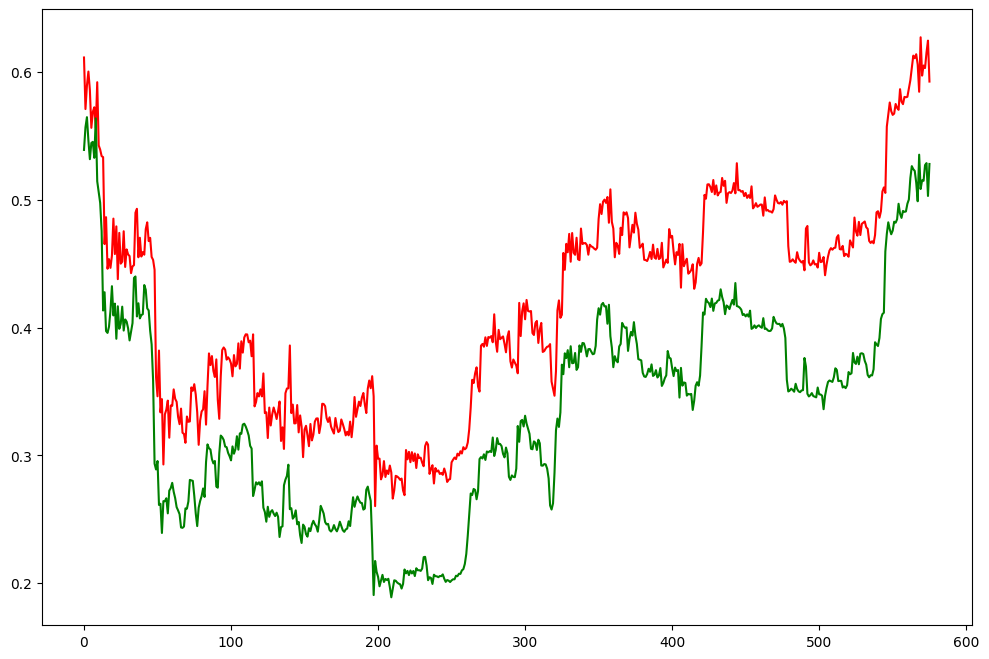

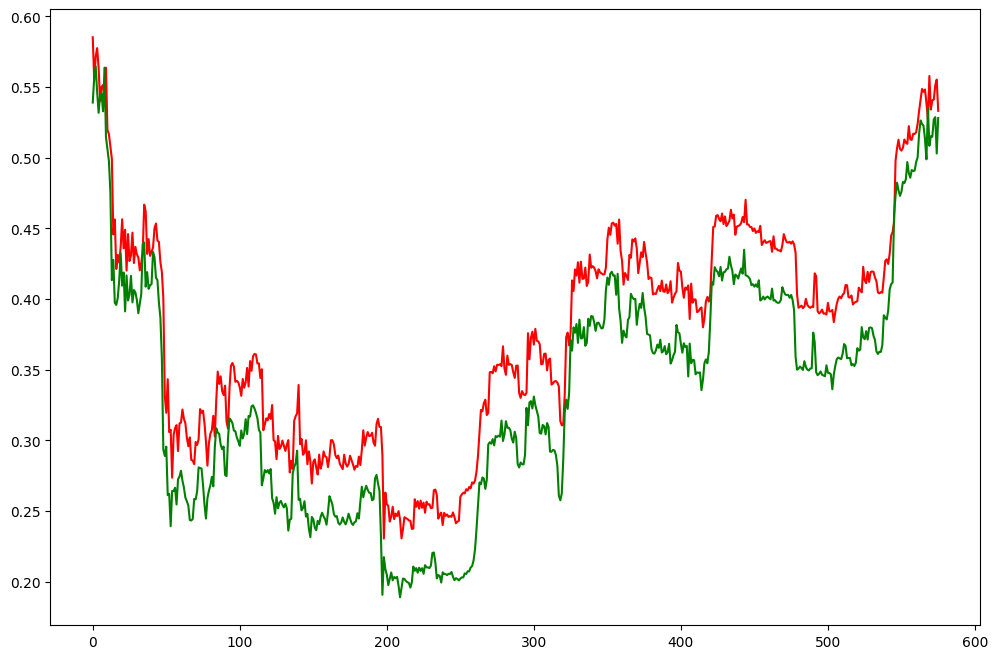

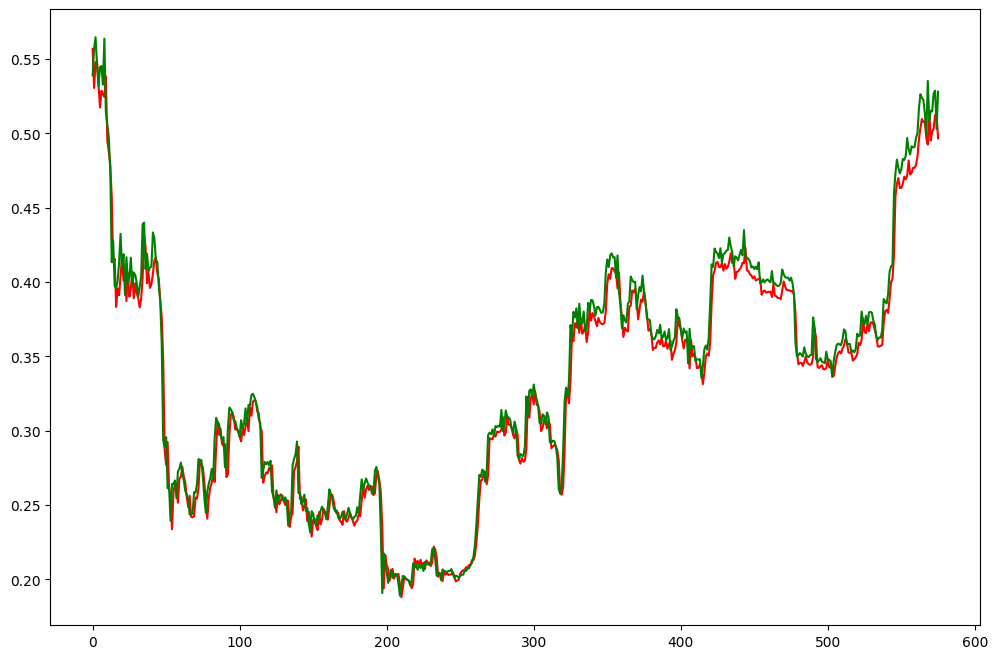

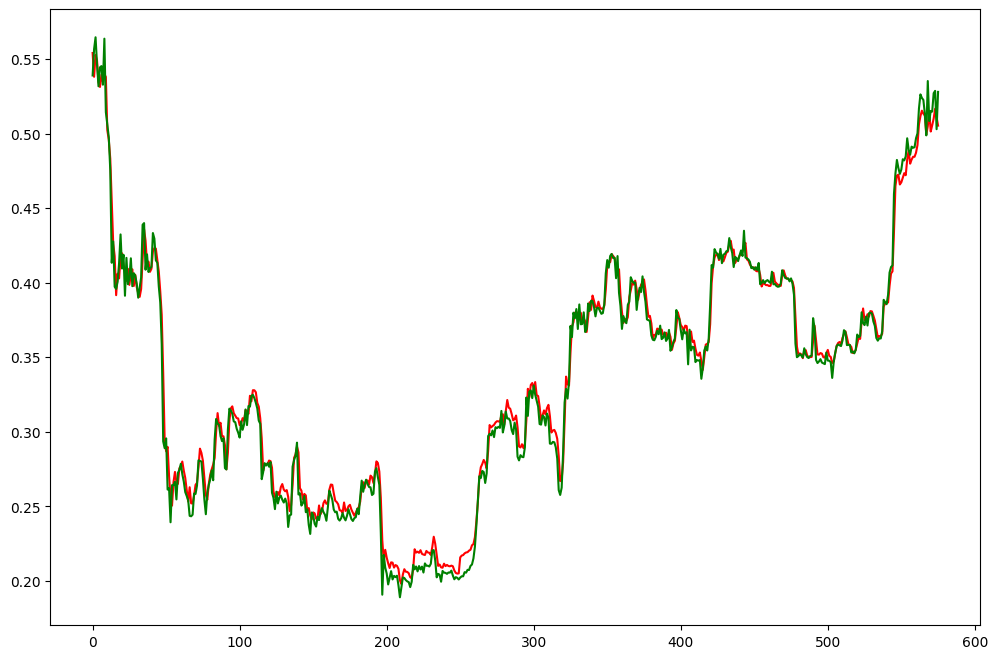

In [196]:
for key in y_test_SM_GRU:
    plt.figure(figsize=(12, 8))
    plt.plot(pd.DataFrame(y_test_SM_GRU[key]),color='red',label='Predicted test value')
    plt.plot(pd.DataFrame(y_test_SM), color ='green',label ='Actual test value' )
    plt.show()

In [197]:
num_elements = len(next(iter(y_test_SM_GRU.values())))
test_GRU_average = []
for i in range(num_elements):
    element_sum = sum(y_test_SM_GRU[key][i] for key in y_test_SM_GRU)
    test_GRU_average.append(element_sum / len(y_test_SM_GRU))
test_GRU_average = pd.DataFrame(test_GRU_average)

In [198]:
num_elements = len(next(iter(y_90_GRU_stacking.values())))
GRU_30_average =[]
GRU_60_average =[]
GRU_90_average =[]
for i in range(num_elements):
    if i <30:
        element_sum_30 = sum(y_30_GRU_stacking[key.replace('90','30')][i] for key in y_30_GRU_stacking)
        GRU_30_average.append(element_sum_30 / len(y_30_GRU_stacking))
    if i <60:
        element_sum_60 = sum(y_60_GRU_stacking[key.replace('90','60')][i] for key in y_60_GRU_stacking)
        GRU_60_average.append(element_sum_60 / len(y_60_GRU_stacking))
    element_sum_90 = sum(y_90_GRU_stacking[key][i] for key in y_90_GRU_stacking)
    GRU_90_average.append(element_sum_90 / len(y_90_GRU_stacking))
GRU_30_average = pd.DataFrame(GRU_30_average)
GRU_60_average = pd.DataFrame(GRU_60_average)
GRU_90_average = pd.DataFrame(GRU_90_average)

In [199]:
num_elements = len(next(iter(y_val_GRU_stacking.values())))
y_val_GRU_stacking_average = []
for i in range(num_elements):
    element_sum = sum(y_val_GRU_stacking[key][i] for key in y_val_GRU_stacking)
    y_val_GRU_stacking_average.append(element_sum / len(y_val_GRU_stacking))
y_val_GRU_stacking_average = pd.DataFrame(y_val_GRU_stacking_average)

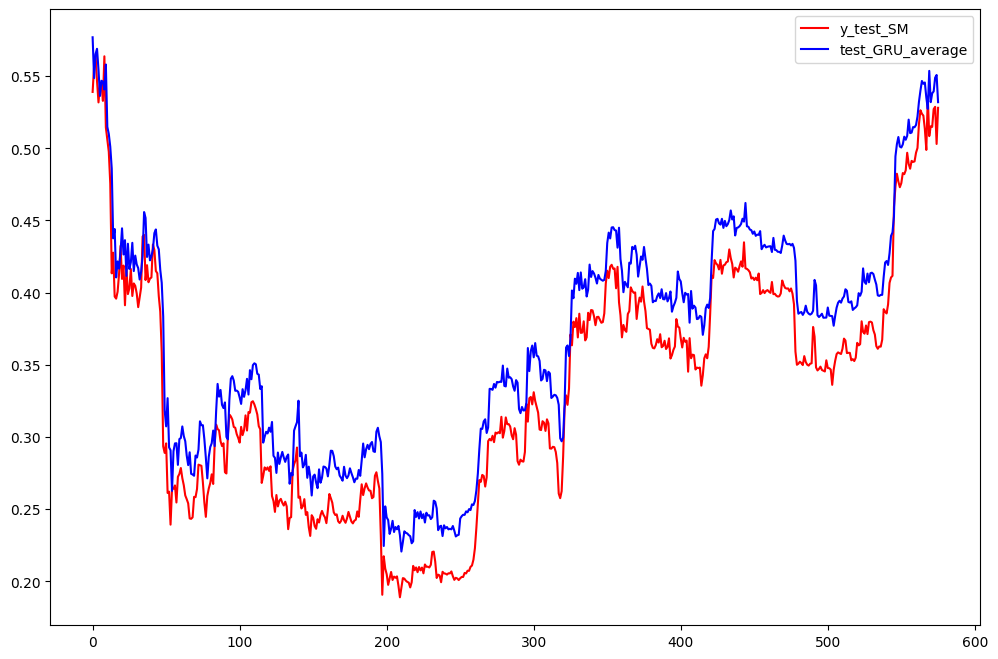

In [200]:
plt.figure(figsize=(12, 8))
plt.plot(pd.DataFrame(y_test_SM).index.to_list(), pd.DataFrame(y_test_SM), color='red', label='y_test_SM')
plt.plot(pd.DataFrame(y_test_SM).index.to_list(), pd.DataFrame(test_GRU_average), color='blue', label='test_GRU_average')
plt.legend()
plt.show()

##### Second base model (LSTM) #####

In [201]:
X_train_LSTM_stacking = pd.DataFrame()
y_30_LSTM_stacking = {}
y_60_LSTM_stacking = {}
y_90_LSTM_stacking = {}
y_train_LSTM_stacking = pd.DataFrame()
y_test_SM_LSTM={}
y_val_LSTM_stacking = {}
i=0
for train_index, test_index in kf.split(X_train_SM):
    X_train_fold, X_test_fold = X_train_SM[train_index], X_train_SM[test_index]
    y_train_fold, y_test_fold = y_train_SM[train_index], y_train_SM[test_index]
    base_model_LSTM.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=1)
    y_test_fold_predict = base_model_LSTM.predict(X_test_fold)
    y_test_SM_LSTM[f'y_test_SM_LSTM_{i}'] = base_model_LSTM.predict(X_test_SM)
    y_30_LSTM_stacking[f'y_30_LSTM_stacking_{i}'] = base_model_LSTM.predict(X_30_SM)
    y_60_LSTM_stacking[f'y_60_LSTM_stacking_{i}'] = base_model_LSTM.predict(X_60_SM)
    y_90_LSTM_stacking[f'y_90_LSTM_stacking_{i}'] = base_model_LSTM.predict(X_90_SM)
    y_val_LSTM_stacking[f'y_val_LSTM_stacking_{i}'] = base_model_LSTM.predict(X_val_SM)
    i+=1
    y_pred_fold_df = pd.DataFrame(y_test_fold_predict, columns=['Prediction'])
    y_test_fold_df = pd.DataFrame(y_test_fold, columns=['Prediction'])
    X_train_LSTM_stacking = pd.concat([X_train_LSTM_stacking, y_pred_fold_df], axis=0, ignore_index=True)
    y_train_LSTM_stacking = pd.concat([y_train_LSTM_stacking,y_test_fold_df],axis=0,ignore_index=True)

Epoch 1/10
27/27 [==============================] - 2s 2ms/step - loss: 0.3690
Epoch 2/10
27/27 [==============================] - 0s 2ms/step - loss: 0.2516
Epoch 3/10
27/27 [==============================] - 0s 3ms/step - loss: 0.1955
Epoch 4/10
27/27 [==============================] - 0s 3ms/step - loss: 0.1495
Epoch 5/10
27/27 [==============================] - 0s 3ms/step - loss: 0.1175
Epoch 6/10
27/27 [==============================] - 0s 3ms/step - loss: 0.0848
Epoch 7/10
27/27 [==============================] - 0s 3ms/step - loss: 0.0751
Epoch 8/10
27/27 [==============================] - 0s 3ms/step - loss: 0.0656
Epoch 9/10
27/27 [==============================] - 0s 4ms/step - loss: 0.0655
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
Epoch 1/10
27/27 [==============================] - 0s 3ms/step - loss: 0.0576
Epoch 2/10
27/27 [==============================] - 0s 3ms/step - loss: 0.0565
Epoch 3/10
27/27 [==============================] - 0s 3ms/step - lo

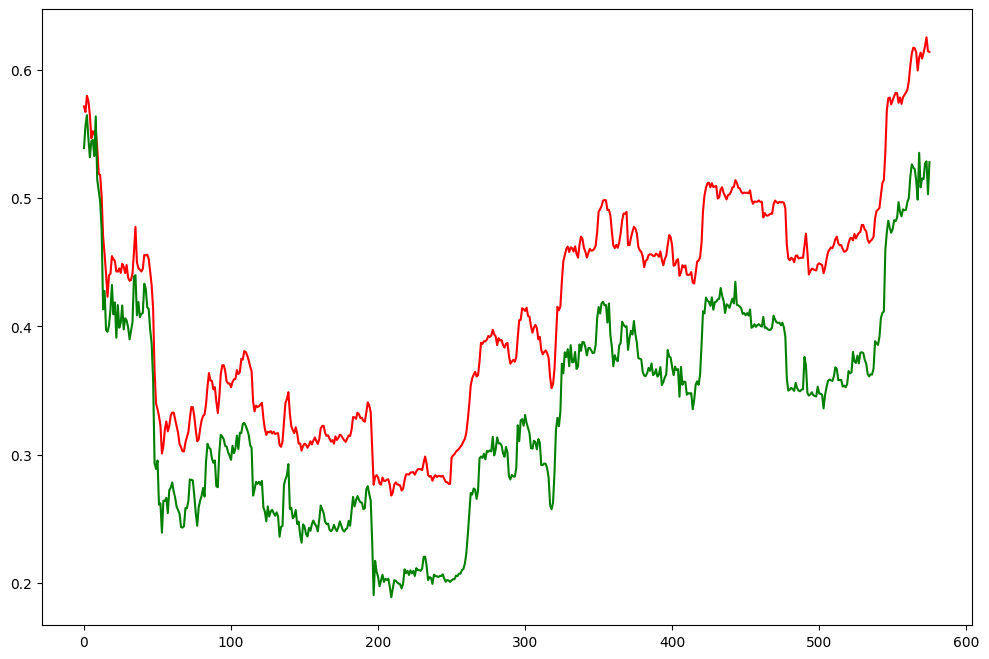

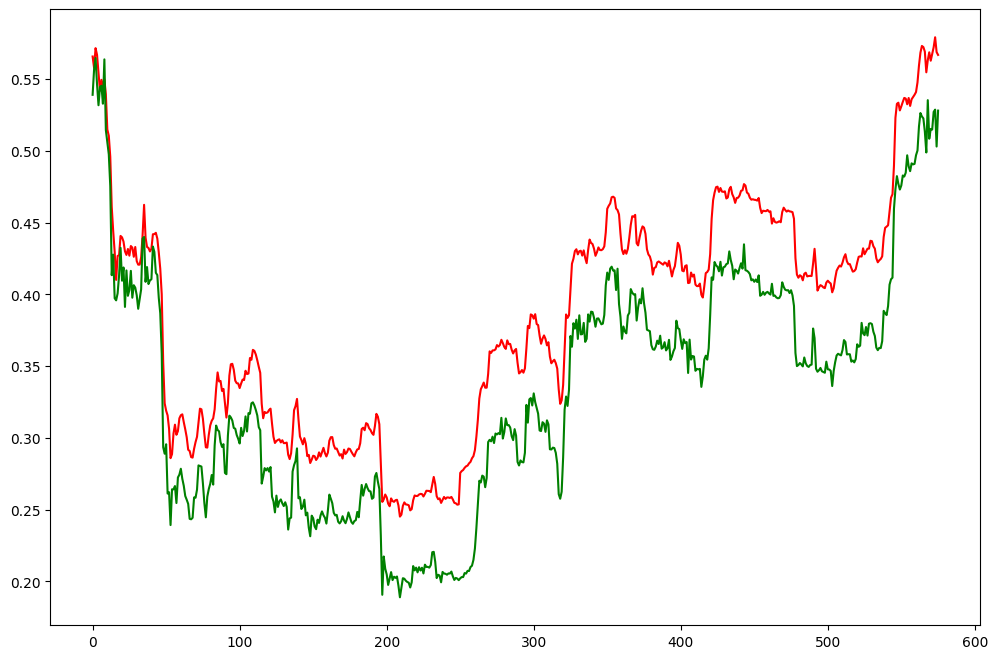

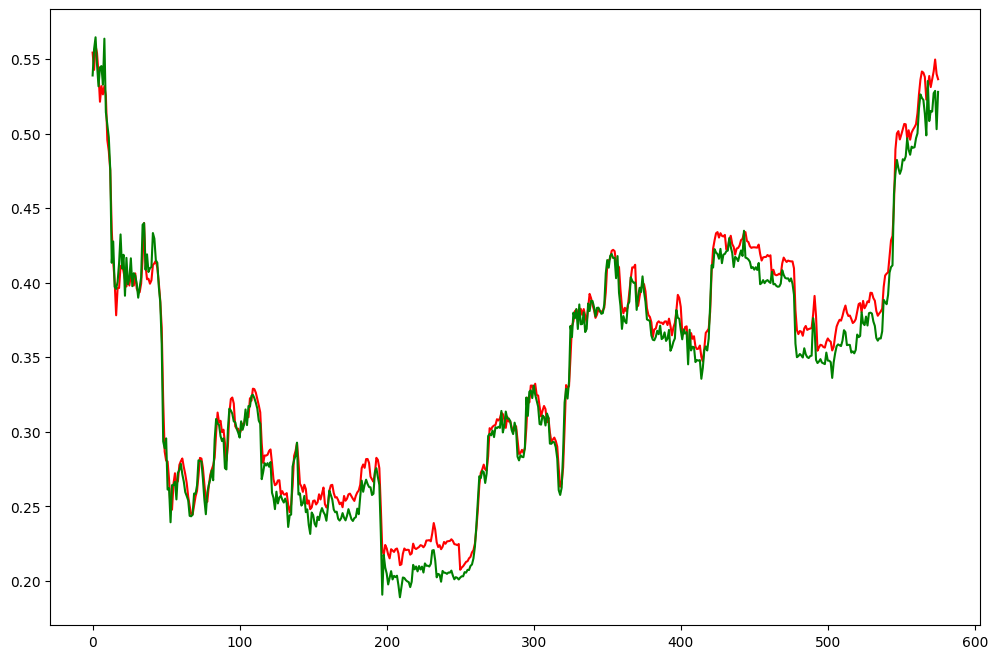

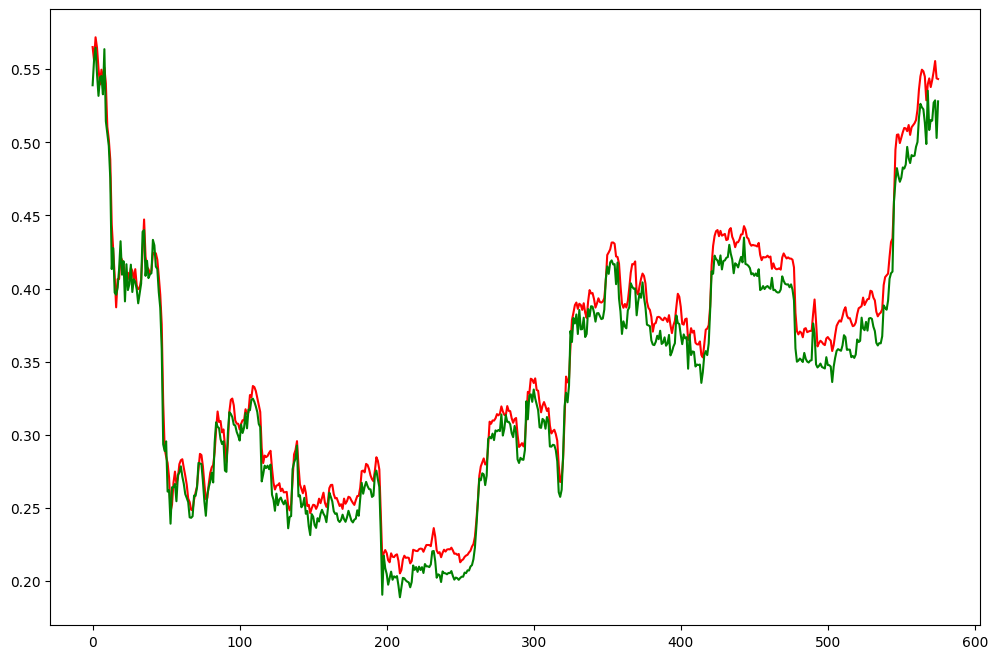

In [202]:
for key in y_test_SM_LSTM:
    plt.figure(figsize=(12, 8))
    plt.plot(pd.DataFrame(y_test_SM_LSTM[key]),color='red',label='Predicted test value')
    plt.plot(pd.DataFrame(y_test_SM), color ='green',label ='Actual test value' )
    plt.show()

In [203]:
num_elements = len(next(iter(y_test_SM_LSTM.values())))
test_LSTM_average = []

for i in range(num_elements):
    element_sum = sum(y_test_SM_LSTM[key][i] for key in y_test_SM_LSTM)
    test_LSTM_average.append(element_sum / len(y_test_SM_LSTM))

test_LSTM_average = pd.DataFrame(test_LSTM_average)

In [204]:
num_elements = len(next(iter(y_90_LSTM_stacking.values())))
LSTM_30_average =[]
LSTM_60_average =[]
LSTM_90_average =[]
for i in range(num_elements):
    if i <30:
        element_sum_30 = sum(y_30_LSTM_stacking[key.replace('90','30')][i] for key in y_30_LSTM_stacking)
        LSTM_30_average.append(element_sum_30 / len(y_30_LSTM_stacking))
    if i <60:
        element_sum_60 = sum(y_60_LSTM_stacking[key.replace('90','60')][i] for key in y_60_LSTM_stacking)
        LSTM_60_average.append(element_sum_60 / len(y_60_LSTM_stacking))
    element_sum_90 = sum(y_90_LSTM_stacking[key][i] for key in y_90_LSTM_stacking)
    LSTM_90_average.append(element_sum_90 / len(y_90_LSTM_stacking))
LSTM_30_average = pd.DataFrame(LSTM_30_average)
LSTM_60_average = pd.DataFrame(LSTM_60_average)
LSTM_90_average = pd.DataFrame(LSTM_90_average)

In [205]:
num_elements = len(next(iter(y_val_LSTM_stacking.values())))
y_val_LSTM_stacking_average = []
for i in range(num_elements):
    element_sum = sum(y_val_LSTM_stacking[key][i] for key in y_val_LSTM_stacking)
    y_val_LSTM_stacking_average.append(element_sum / len(y_val_LSTM_stacking))
y_val_LSTM_stacking_average = pd.DataFrame(y_val_LSTM_stacking_average)

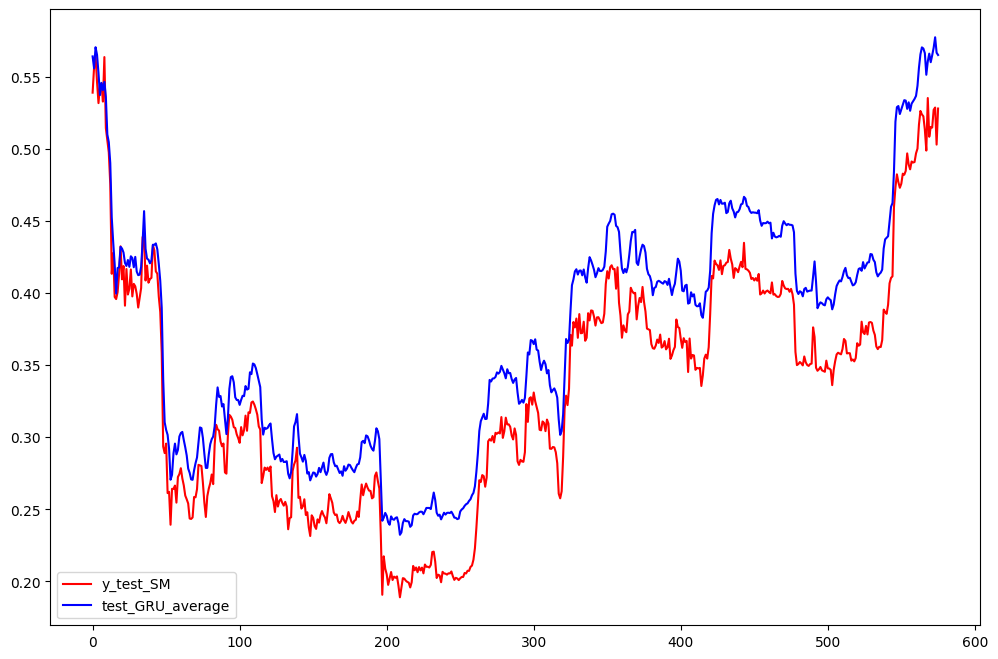

In [206]:
plt.figure(figsize=(12, 8))
plt.plot(pd.DataFrame(y_test_SM).index.to_list(), pd.DataFrame(y_test_SM), color='red', label='y_test_SM')
plt.plot(pd.DataFrame(y_test_SM).index.to_list(), pd.DataFrame(test_LSTM_average), color='blue', label='test_GRU_average')
plt.legend()
plt.show()

#### Train dataset for meta model ####

In [211]:
X_train_meta = pd.concat([X_train_GRU_stacking, X_train_LSTM_stacking], axis=1, ignore_index=True)
y_train_meta = y_train_GRU_stacking

#### Test dataset for meta model ####

In [212]:
y_test_meta = pd.concat([test_GRU_average,test_LSTM_average],axis=1, ignore_index=True)
X_val_meta = pd.concat([y_val_GRU_stacking_average,y_val_LSTM_stacking_average],axis=1, ignore_index=True)

#### meta model training ####

In [214]:
X_train_meta = X_train_meta.values
y_train_meta = y_train_meta.values.reshape(-1)
X_test_meta  = y_test_meta.values
y_test_meta  = y_test_SM
X_val_meta = X_val_meta.values

X_30_meta = pd.concat([GRU_30_average,LSTM_30_average],axis=1, ignore_index=True)
X_60_meta = pd.concat([GRU_60_average,LSTM_60_average],axis=1, ignore_index=True)
X_90_meta = pd.concat([GRU_90_average,LSTM_90_average],axis=1, ignore_index=True)

In [215]:
print('X train shape of meta model: ', X_train_meta.shape)
print('y train shape of meta model: ',y_train_meta.shape)
print('X test shape of meta model', X_test_meta.shape)
print('y test shape of meta model',y_test_meta.shape)

X train shape of meta model:  (1152, 2)
y train shape of meta model:  (1152,)
X test shape of meta model (576, 2)
y test shape of meta model (576,)


In [216]:
meta_model = LinearRegression()
meta_model.fit(X_train_meta, y_train_meta)

LinearRegression()

In [226]:
pred_test_meta = meta_model.predict(X_test_meta)
pred_val_meta = meta_model.predict(X_val_meta)
pred_30_meta = meta_model.predict(X_30_meta)
pred_60_meta = meta_model.predict(X_60_meta)
pred_90_meta = meta_model.predict(X_90_meta)

In [218]:
mape = mean_absolute_percentage_error(y_test_meta, pred_test_meta)
mae = mean_absolute_error(y_test_meta,pred_test_meta)
mse = mean_squared_error(y_test_meta, pred_test_meta)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

Mean Absolute Percentage Error: 0.12564774448929555
Mean Absolute Error: 0.038958581641330176
Root Mean Squared Error: 0.040446066644135185


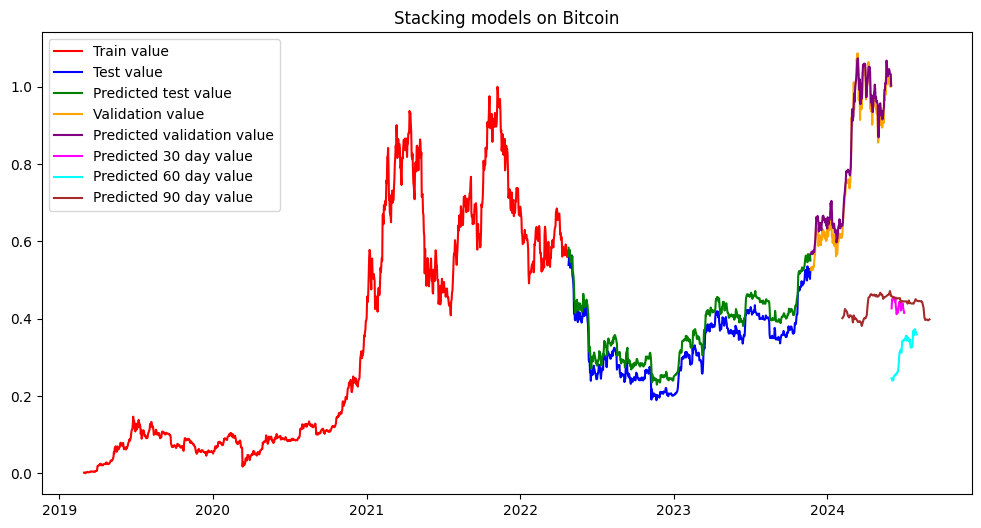

In [231]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train_scale).index.to_list(),pd.DataFrame(y_train_SM),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(y_test_SM), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(pred_test_meta), color='green', label='Predicted test value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(y_val_scale),color='orange', label='Validation value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(pred_val_meta),color='purple', label='Predicted validation value')
plt.plot(pd.DataFrame(y_30_scale).index.to_list(), pd.DataFrame(pred_30_meta), color='magenta', label='Predicted 30 day value')
plt.plot(pd.DataFrame(y_60_scale).index.to_list(), pd.DataFrame(pred_60_meta), color='cyan', label='Predicted 60 day value')
plt.plot(pd.DataFrame(y_90_scale).index.to_list(), pd.DataFrame(pred_90_meta), color='brown', label='Predicted 90 day value')
plt.title("Stacking models on Bitcoin")
plt.legend()
plt.show()

### ARIMA ###

In [220]:
y_train_ARIMA= y_train_scale

y_test_ARIMA = y_test_scale

y_val_ARIMA = y_val_scale

In [221]:
model_ARIMA = ARIMA(y_train_ARIMA, order=(3, 0, 3)).fit()

d:\USER\anaconda3\envs\e4_jupyter_notebook_assignment\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\USER\anaconda3\envs\e4_jupyter_notebook_assignment\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\USER\anaconda3\envs\e4_jupyter_notebook_assignment\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [222]:
pred_test_ARIMA = model_ARIMA.forecast(steps=576)
pred_val_ARIMA = model_ARIMA.forecast(steps=192)
pred_30_ARIMA = model_ARIMA.forecast(steps = 30)
pred_60_ARIMA = model_ARIMA.forecast(steps = 60)
pred_90_ARIMA = model_ARIMA.forecast(steps = 90)


In [223]:
mape = mean_absolute_percentage_error(y_test_ARIMA, pred_test_ARIMA)
mae = mean_absolute_error(y_test_ARIMA,pred_test_ARIMA)
mse = mean_squared_error(y_test_ARIMA, pred_test_ARIMA)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

Mean Absolute Percentage Error: 0.5194309154281822
Mean Absolute Error: 0.1408187685273725
Root Mean Squared Error: 0.171132947902063


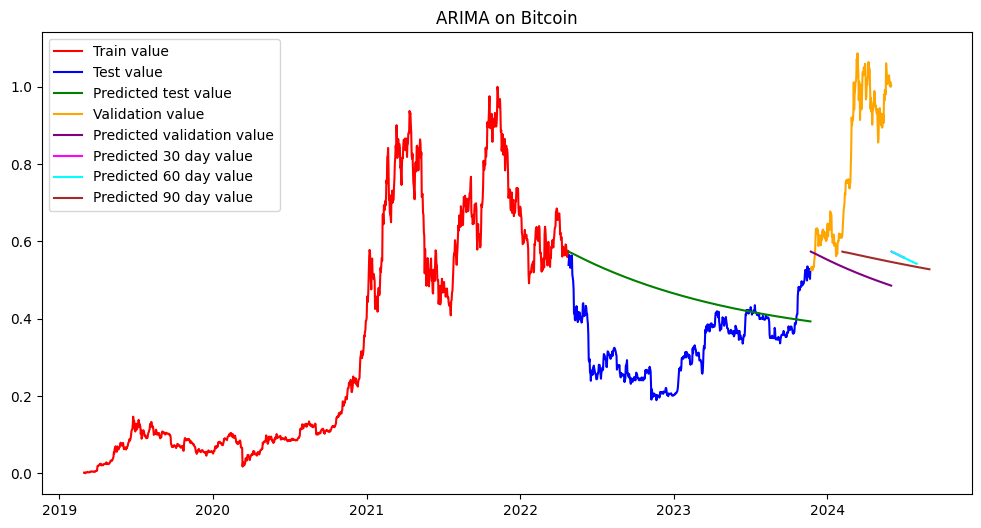

In [232]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train_scale).index.to_list(),pd.DataFrame(y_train_ARIMA),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(y_test_ARIMA), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(pred_test_ARIMA), color='green', label='Predicted test value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(y_val_ARIMA),color='orange', label='Validation value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(pred_val_ARIMA),color='purple', label='Predicted validation value')
plt.plot(pd.DataFrame(y_30_scale).index.to_list(), pd.DataFrame(pred_30_ARIMA), color='magenta', label='Predicted 30 day value')
plt.plot(pd.DataFrame(y_60_scale).index.to_list(), pd.DataFrame(pred_60_ARIMA), color='cyan', label='Predicted 60 day value')
plt.plot(pd.DataFrame(y_90_scale).index.to_list(), pd.DataFrame(pred_90_ARIMA), color='brown', label='Predicted 90 day value')
plt.title("ARIMA on Bitcoin")
plt.legend()
plt.show()